# About
Analysis of Daily Returns on Bitcoin and Ether.

##### Datasource:
* Bitcoin: https://www.coindesk.com/price/bitcoin
* Ether: https://www.coindesk.com/price/ethereum

##### Context:
* Bitcoin launched in 2009 but was obscure until about 2013.
* Ether launched in July 2015.

In [1]:
from datetime import datetime

from fattails.metrics import get_survival_probability
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Import code from this repository
import sys; sys.path.insert(0, '../')  # Add root directory to path for imports

from utils.price import prices_to_returns

# Setup

In [3]:
btc_filepath = '../data/BTCUSD_CoinDesk_2013-10-01_2021-05-08.csv'
eth_filepath = '../data/ETHUSD_CoinDesk_2015-08-09_2021-05-08.csv'

### Load Data

In [4]:
# Function to read the Price Files
def read_price_file(filepath):
    """ Read closing prices from filepath.
    
    Assumes the format of CoinDesk's price data downloads.
    """
    price_df = pd.read_csv(filepath, index_col=1, parse_dates=[1])
    
    closing_price_sr = price_df['Closing Price (USD)'].rename('prices')
    
    return closing_price_sr

Load Prices:

In [5]:
# Load Bitcoin Prices
btc_prices = read_price_file(btc_filepath)
btc_prices.head(3)

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
Name: prices, dtype: float64

In [6]:
# Load Ether Prices
eth_prices = read_price_file(eth_filepath)
eth_prices.head(3)

Date
2015-08-09    0.909046
2015-08-10    0.692321
2015-08-11    0.668067
Name: prices, dtype: float64

Calculate Returns:

In [7]:
# Calculate Returns
btc_returns = 100*prices_to_returns(btc_prices)  # Scale by 100 so 0.01 becomes 1% etc.

eth_returns = 100*prices_to_returns(eth_prices)
eth_returns.head(3)

Date
2015-08-10   -23.840928
2015-08-11    -3.503288
2015-08-12    27.255350
Name: prices, dtype: float64

Combine into one dataframe:

In [8]:
# Create DataFrame
returns_df = pd.concat([btc_returns, eth_returns], \
                       keys=['btc_returns','eth_returns'], \
                       axis=1, join='outer')

returns_df.head(3)

,btc_returns,eth_returns
Date,,
2013-10-02,1.455671,NaN
2013-10-03,-13.447188,NaN
2013-10-04,9.292118,NaN


### Missing Data Check

In [9]:
# NaN Values in ETH Prices
eth_prices.loc[eth_prices.isna()]

Series([], Name: prices, dtype: float64)

In [10]:
# NaN Values in BTC Prices
btc_prices.loc[btc_prices.isna()]

Series([], Name: prices, dtype: float64)

# Analyse

Summary statistics:

In [11]:
# Observed Range Summary
returns_df.agg(['max', 'mean', 'min']) \
          .astype(int)  # Remove decimals

,btc_returns,eth_returns
max,35,54
mean,0,0
min,-27,-34


# Plot the Prices

Don't be fooled by absolute levels. In percentage return terms 2017 was better than 2021 so far.

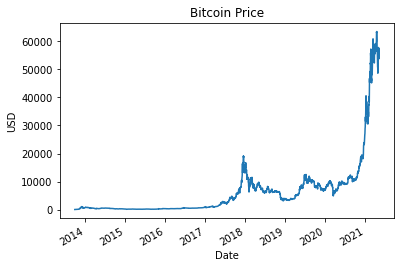

In [12]:
# Bitcoin Price History
btc_prices.plot(ylabel='USD', title='Bitcoin Price');

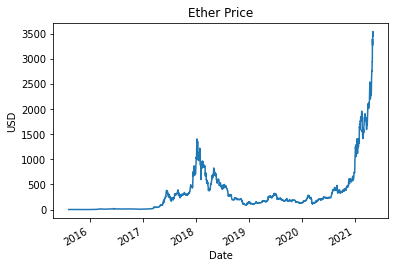

In [13]:
# Ether Price History
eth_prices.plot(ylabel='USD', title='Ether Price');

### Plot the Returns

Plot daily returns:

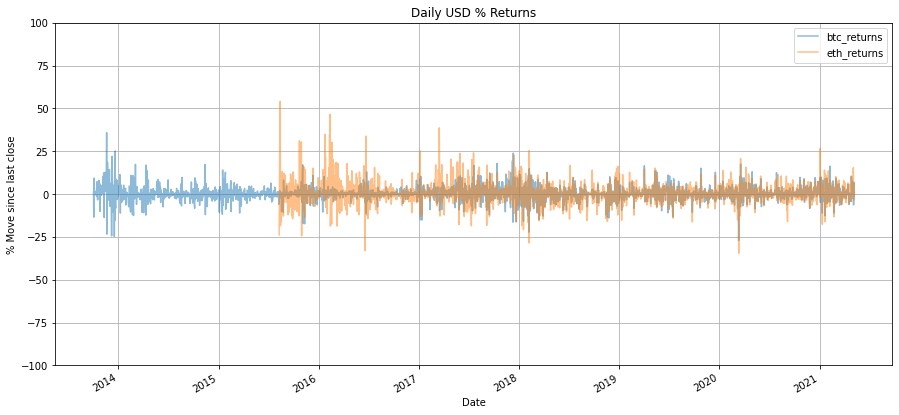

In [14]:
# Daily Returns
returns_df.plot(figsize=[15,7], alpha=0.5, grid=True, \
                ylim=[-100,100],  ylabel='% Move since last close', \
                title='Daily USD % Returns'); # ylabel requires pandas >=1.2.0

Daily returns in separate plots:

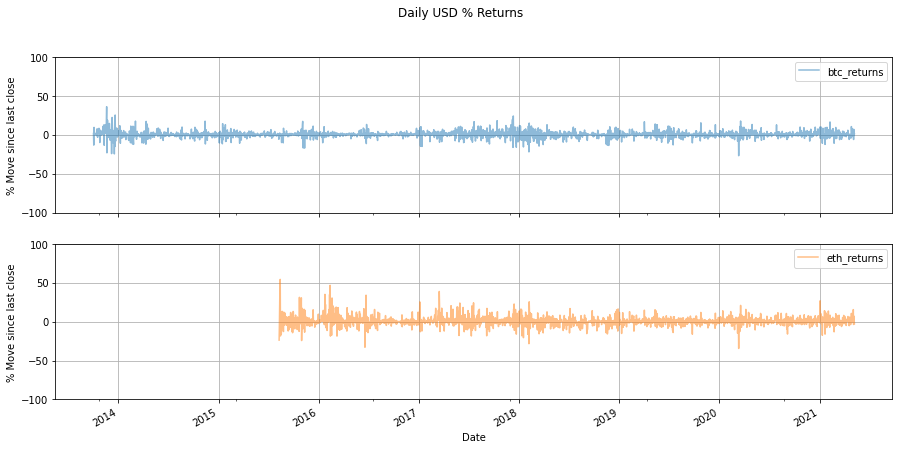

In [15]:
# Daily Returns
returns_df.plot(figsize=[15,7], alpha=0.5, grid=True, \
                ylim=[-100,100],  ylabel='% Move since last close', \
                title='Daily USD % Returns', subplots=True); # ylabel requires pandas >=1.2.0

# Distribution
Historic distribution of the daily percentage returns.

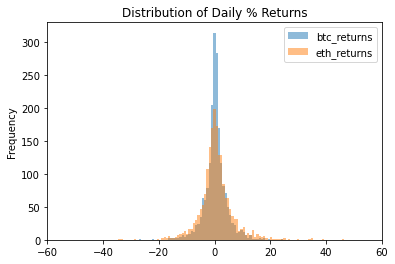

In [16]:
# Since 2016
start_year = 2016
returns_df.loc[returns_df.index>datetime(start_year,1,1)] \
          .plot(kind='hist', bins=100, alpha=0.5, \
                xlim=[-60, 60], \
                xlabel='Daily % Return', \
                title='Distribution of Daily % Returns');

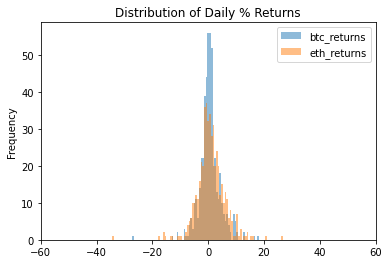

In [17]:
# Since 2020
start_year = 2020
returns_df.loc[returns_df.index>datetime(start_year,1,1)] \
          .plot(kind='hist', bins=100, alpha=0.5, \
                xlim=[-60, 60], \
                xlabel='Daily % Return', \
                title='Distribution of Daily % Returns');

### Deviations

Below is a plot of mean deviation for each year.
* The **average daily deviation is mid to low single digit percentages.** 
* The high values in 2013 and 2015 are probably caused by bitcoin and ethereum being at an early stage of adoption in those years respectively.

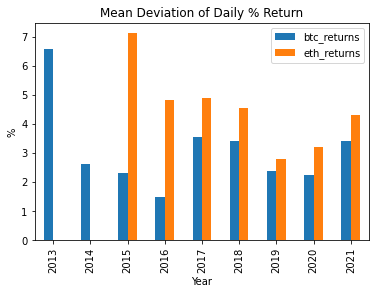

In [18]:
yearly_mean_deviation = returns_df.groupby(returns_df.index.year) \
                                  .mad()

yearly_mean_deviation.plot(kind='bar', title='Mean Deviation of Daily % Return', \
                           xlabel='Year', ylabel='%');

# Transaction Risk
Roughly trying to answer: _what's the risk of holding bitcoin for one day_

In [19]:
# Helper Function
def get_survival_df(value_sr):
    """Dataframe with values and their survival probability.
    
    Ordered from high survival probability.
    """
    survival_prob = get_survival_probability(value_sr)

    survival_df = pd.concat([value_sr, survival_prob], axis=1)
    survival_df.sort_values(by='survival_probability', ascending=False, inplace=True)

    return survival_df
    

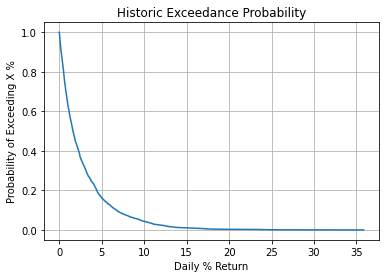

In [20]:
# Survival Probability
survival_df = get_survival_df(returns_df.btc_returns.abs())
survival_df.plot('btc_returns', 'survival_probability', grid=True, legend=None, \
                 xlabel='Daily % Return', ylabel='Probability of Exceeding X %', 
                 title='Historic Exceedance Probability');